In [61]:
import geopandas
import geojson
import json
import sys
import shapely
from shapely.geometry import shape
from haversine import haversine, Unit
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import LineString
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import geopy
import geopy.distance
import pyproj
from shapely.ops import transform
from functools import partial

In [65]:
#reading the shapefile and converting it to geojson
myshpfile = geopandas.read_file('layers\\POLYGON.shp')
myshpfile.to_file('myJson.geojson', driver='GeoJSON')
with open('myJson.geojson') as f:
#print(f[0].features[0].geometry)
    
    features = json.load(f)["features"] 
    #var_name[0].features[0].geometry
    #var_name[1].features[0].geometry  map, 1 se obstacles
    #var_name[2].features[]
maparea = ([shape(feature["geometry"]).buffer(0) for feature in features])

In [66]:
# saving the obstacles in a list
# give length of obstacle
obstacles = np.zeros([3],dtype = 'O')
for x in range(0,3):
    obstacles[x] = maparea[x+1]
print(obstacles)

In [33]:
# The bounds of the map minx miny maxx maxy
outer_rect = maparea[0].bounds

In [34]:
def gridpoints(rect,dist):
    height = haversine((rect[1],rect[0]),(rect[3],rect[0]))
    length = haversine((rect[1],rect[0]),(rect[1],rect[2]))
    d = geopy.distance.distance(kilometers = dist)
    horizontalcells = ceil(length/dist)
    verticalcells = ceil(height/dist)
    
    latitudelist = []
    start = geopy.Point(rect[1],rect[0])
    for _ in range(verticalcells):
        latitudelist.append(start)
        final = d.destination(point=start, bearing=0)
        start = final
    latitudelist.append(start)
    
    longitudelist = []
    start = geopy.Point(rect[1],rect[0])
    for _ in range(horizontalcells):
        longitudelist.append(start)
        final = d.destination(point=start, bearing=90)
        start = final
    longitudelist.append(start)
    
    return latitudelist,longitudelist,verticalcells,horizontalcells

In [35]:
latitudelist,longitudelist,vertical,horizontal = gridpoints(outer_rect,0.1) #binding rectangle and distance are sent as parameters

In [36]:
mapboundary = maparea[0]

In [37]:
bounding_rectangle_grid= Polygon([(longitudelist[0][1],latitudelist[0][0]),(longitudelist[horizontal][1],latitudelist[0][0]),(longitudelist[horizontal][1],latitudelist[vertical][0]),(longitudelist[0][1],latitudelist[vertical][0])]) 

In [38]:
print(bounding_rectangle_grid)

POLYGON ((72.79214859008789 18.92008994441299, 72.84910583784675 18.92008994441299, 72.84910583784675 19.02578888118662, 72.79214859008789 19.02578888118662, 72.79214859008789 18.92008994441299))


In [39]:
outside_map_traverse_area = bounding_rectangle_grid.difference(mapboundary) # 

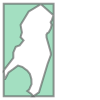

In [40]:
outside_map_traverse_area

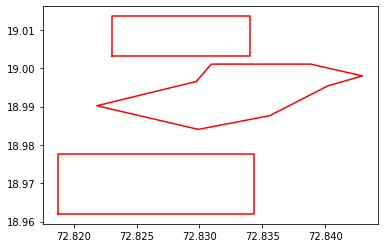

In [41]:
for z in obstacles:
    x,y = z.exterior.xy
    plt.plot(x,y, color = "red")
#plt.plot(latitudelist,longitudelist,color = "black")

In [42]:
c = np.zeros([vertical,horizontal],dtype = int)
lookup_c = np.zeros([vertical,horizontal],dtype = 'O')

In [43]:
obstacle_partial = {}
for q in range(len(obstacles)):
    obstacle_partial[q] = []

In [44]:
boundary_partial = []

In [45]:
for x in range(len(latitudelist)-1):
    for y in range(len(longitudelist)-1):
        square = Polygon([(longitudelist[y][1],latitudelist[x][0]),(longitudelist[y+1][1],latitudelist[x][0]),(longitudelist[y+1][1],latitudelist[x+1][0]),(longitudelist[y][1],latitudelist[x+1][0])]) 
        lookup_c[x,y] = square.centroid
        # storing value of centre point
        if(outside_map_traverse_area.contains(square)):
            c[x,y] = -1  # region outside the map but inside the gird
        if(square.intersects(mapboundary)):
                z = square.intersection(mapboundary)
                if(not z.is_empty):
                    if(mapboundary.contains(z)):
                        c[x,y] = 0 #region inside the map
                    else:
                        c[x,y] = 2 #2 is for boundary partial
                        boundary_partial.append([x,y])
                
        for q in range(len(obstacles)):
            if(square.intersects(obstacles[q])):
                z = square.intersection(obstacles[q])
                if(not z.is_empty):
                    if(z.within(obstacles[q])):
                        c[x,y] = -1    # inside the obstacle i.e fully covered
                    else:
                        if(not c[x,y] == 2):  
                            c[x,y] = -2 # partially covered obstacle
                            a = obstacle_partial[q]
                            a.append([x,y])
            elif(square.contains(obstacles[q])):
                c[x,y] = -2 # partially covered obstacle

In [46]:
print(lookup_c[0][0])

POINT (72.79262323381941 18.92054165182155)


In [51]:
darpmatrix = np.zeros([vertical,horizontal],dtype = int)
np.copyto(darpmatrix,c)

In [59]:
darpmatrix[darpmatrix==-2] = -1
darpmatrix[darpmatrix==2]  = -1

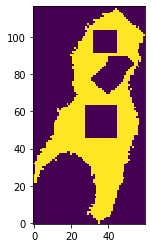

In [60]:
import matplotlib.pyplot as plt
a = plt.imshow(c, interpolation = 'nearest')
plt.gca().invert_yaxis()

In [20]:
obstacle_partial_neighbours = {}
for q in range(len(obstacles)):
    obstacle_partial_neighbours[q] = []

In [21]:
def neighboursA(x, y):
    for dx in [-1, 1]:
        yield x + dx, y
    for dy in [-1, 1]:
        yield x, y + dy

In [22]:
for x in obstacle_partial:
    for y in obstacle_partial[x]:
        if(not c[y[0]][y[1]]==2):
            for dx, dy in neighboursA(y[0],y[1]):
                if (c[dx][dy]== 0):
                    obstacle_partial_neighbours[x].append([dx,dy])

In [23]:
for x in obstacle_partial_neighbours:
    for y in obstacle_partial_neighbours[x]:
        c[y[0]][y[1]] = 3

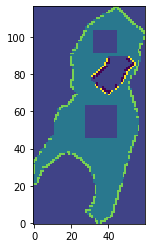

In [24]:
import matplotlib.pyplot as plt
a = plt.imshow(c, interpolation = 'nearest')
plt.gca().invert_yaxis()

In [25]:
boundary_partial_neighbours = []

In [26]:
for x in boundary_partial:
    if(x[0]>0 and x[0]<vertical-1 and x[1]>0 and x[1]<horizontal-1):
        for dx, dy in neighboursA(x[0],x[1]):
            if (c[dx][dy]== 0):
                boundary_partial_neighbours.append([dx,dy])

In [27]:
for x in boundary_partial_neighbours:
    c[x[0]][x[1]] = 6

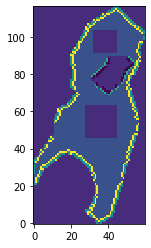

In [28]:
import matplotlib.pyplot as plt
a = plt.imshow(c, interpolation = 'nearest')
plt.gca().invert_yaxis()

In [30]:
import pyvisgraph as vg

In [31]:
x,y = obstacles[0].exterior.coords.xy
for _ in range(len(x)):
    print(x[_],y[_])

72.82304763793945 19.003211287614203
72.82304763793945 19.013598540111825
72.83403396606445 19.013598540111825
72.83403396606445 19.003211287614203
72.82304763793945 19.003211287614203


In [32]:
polygons = []
for shape in obstacles:
    polygon = []
    if(not shape.geom_type=="Polygon"):
        x,y = shape.xy
        print(x,y)
    else:
        x, y = shape.exterior.coords.xy
    for _ in range(len(x)):
        polygon.append(vg.Point(x[_], y[_]))
        polygons.append(polygon)

In [38]:
print(polygons)

[[Point(72.82, 19.00), Point(72.82, 19.01), Point(72.83, 19.01), Point(72.83, 19.00)], [Point(72.82, 19.00), Point(72.82, 19.01), Point(72.83, 19.01), Point(72.83, 19.00)], [Point(72.82, 19.00), Point(72.82, 19.01), Point(72.83, 19.01), Point(72.83, 19.00)], [Point(72.82, 19.00), Point(72.82, 19.01), Point(72.83, 19.01), Point(72.83, 19.00)], [Point(72.82, 19.00), Point(72.82, 19.01), Point(72.83, 19.01), Point(72.83, 19.00)], [Point(72.82, 18.96), Point(72.82, 18.98), Point(72.83, 18.98), Point(72.83, 18.96)], [Point(72.82, 18.96), Point(72.82, 18.98), Point(72.83, 18.98), Point(72.83, 18.96)], [Point(72.82, 18.96), Point(72.82, 18.98), Point(72.83, 18.98), Point(72.83, 18.96)], [Point(72.82, 18.96), Point(72.82, 18.98), Point(72.83, 18.98), Point(72.83, 18.96)], [Point(72.82, 18.96), Point(72.82, 18.98), Point(72.83, 18.98), Point(72.83, 18.96)], [Point(72.83, 19.00), Point(72.83, 19.00), Point(72.84, 19.00), Point(72.84, 19.00), Point(72.84, 19.00), Point(72.84, 18.99), Point(72.83,

In [33]:
graph = vg.VisGraph()

In [34]:
graph.build(polygons)

100%|██████████| 2/2 [00:00<00:00, 250.69it/s]


In [49]:
initial = lookup_c[40][20].xy
final = lookup_c[50][42].xy
print(initial[0][0])

72.81160898307775


In [41]:
shortest = graph.shortest_path(vg.Point(initial[0][0],initial[1][0]), vg.Point(final[0][0],final[1][0]))

In [42]:
print(shortest)

[Point(72.81, 18.96), Point(72.82, 18.96), Point(72.83, 18.97)]


In [43]:
path_distance = 0
prev_point = shortest[0]
for point in shortest[1:]:
    path_distance += haversine((prev_point.y, prev_point.x), (point.y, point.x))
    prev_point = point

In [44]:
print(path_distance)

2.4582859804919046


In [57]:
list_of_fuelstations = []

In [58]:
circles = []

In [59]:
def fuelchecker(mapboundary):
    for x in list_of_fuelstations:
        circles.append(x.buffer(distance))
    fuelling_range = unary_union(circles)
    if(mapboundary.within(fuelling_range)):
        print("All good")
    else:
        print("Some Points are outside the fuelling station!")
        print("Taking them as obstacles")
        mapboundary = mapboundary.intersection(feulling_range)

In [60]:
fuelchecker(mapboundary)

Some Points are outside the fuelling station!
Taking them as obstacles


NameError: name 'feulling_range' is not defined

In [61]:
import geopy
import geopy.distance

In [62]:
start = geopy.Point(-48.853, 2.349)

In [63]:
d = geopy.distance.distance(kilometers = 1)

In [64]:
final = d.destination(point=start, bearing=90)

In [65]:
print(final)

48 51m 10.7971s S, 2 21m 45.4551s E


In [66]:
final

Point(-48.85299919479592, 2.362626412505501, 0.0)